# DA5401 – Assignment 5  
## Manifold Visualization and Data Veracity in Multi-Label Datasets  

---
#### Name - Shlok Shetty
#### Roll no - MM22B003
### Introduction  
This assignment focuses on understanding how **manifold-learning techniques** can be used to explore and interpret **high-dimensional multi-label data**.  
Real-world datasets often contain hundreds of correlated features and overlapping labels, making it difficult to visualize their structure directly in the input space.  
By projecting such data onto low-dimensional manifolds, we can observe patterns that reveal underlying geometry, potential label inconsistencies, and sources of uncertainty.  

The assignment is divided into multiple questions that examine these ideas through practical experimentation.  
Earlier questions introduce the theoretical aspects of manifold learning and discuss how data veracity (accuracy, consistency, and reliability of data) affects model performance.  
**Question 2**, presented here, builds upon those concepts by applying manifold-learning algorithms to a benchmark multi-label dataset and visually analyzing the results.  

Specifically, we aim to:  
1. Load and preprocess a multi-label dataset in ARFF format.  
2. Apply nonlinear dimensionality-reduction methods such as **t-SNE** and **Isomap** to obtain two-dimensional embeddings.  
3. Examine the resulting manifolds to identify **outliers, noisy samples, and ambiguous label regions**, which reflect real-world data-veracity challenges.  
4. Compare the neighborhood-preservation characteristics of t-SNE and Isomap and relate them to the curvature and complexity of the data manifold.  

All computations are performed in **Python (v3.12)** using libraries from the scientific-computing ecosystem such as `numpy`, `pandas`, `scikit-learn`, and `matplotlib`.  
The analyses are executed inside a Jupyter environment to provide a clear, step-by-step record of the experimental workflow.


In [7]:
import numpy as np
import pandas as pd
from scipy.io import arff
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from scipy.stats import zscore
from sklearn.manifold import Isomap
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET


In [8]:
data, meta = arff.loadarff('yeast.arff')
df = pd.DataFrame(data)

df = df.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
print('Loaded ARFF: rows =', df.shape[0], ', columns =', df.shape[1])

Loaded ARFF: rows = 2417 , columns = 117


In [9]:
tree = ET.parse('yeast.xml')
root = tree.getroot()
labels = root.findall('.//{http://mulan.sourceforge.net/labels}label')
label_names = [lbl.attrib['name'] for lbl in labels]
print('Label names found in XML (count):', len(label_names))
print(label_names)

Label names found in XML (count): 14
['Class1', 'Class2', 'Class3', 'Class6', 'Class4', 'Class10', 'Class11', 'Class5', 'Class7', 'Class8', 'Class9', 'Class12', 'Class13', 'Class14']


## Question 2 – Part A : Data Loading and Preprocessing  

The first step is to load the **Yeast** multi-label dataset and examine its structure.  
We work directly with the single file `yeast.csv`, which contains all samples.  
Each record describes a gene sequence through **103 numeric features** and is associated with **14 binary label columns** indicating its functional categories.  

In this sub-section we will:
1. Load the dataset into a Pandas DataFrame.  
2. Verify the number of instances and attributes.  
3. Separate the **features (X)** and **labels (Y)** for later visualization.


In [10]:
n_labels = 14
X_df = df.iloc[:, :-n_labels].astype(float)
Y_df = df.iloc[:, -n_labels:].astype(int)

Y_df.columns = label_names
print('X shape:', X_df.shape)
X_df.head()

X shape: (2417, 103)


,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Att94,Att95,Att96,Att97,Att98,Att99,Att100,Att101,Att102,Att103
0,0.004168,-0.170975,-0.156748,-0.142151,0.058781,0.026851,0.197719,0.041850,0.066938,-0.056617,...,0.006166,-0.012976,-0.014259,-0.015024,-0.010747,0.000411,-0.032056,-0.018312,0.030126,0.124722
1,-0.103956,0.011879,-0.098986,-0.054501,-0.007970,0.049113,-0.030580,-0.077933,-0.080529,-0.016267,...,0.007680,0.027719,-0.085811,0.111123,0.050541,0.027565,-0.063569,-0.041471,-0.079758,0.017161
2,0.509949,0.401709,0.293799,0.087714,0.011686,-0.006411,-0.006255,0.013646,-0.040666,-0.024447,...,0.096277,-0.044932,-0.089470,-0.009162,-0.012010,0.308378,-0.028053,0.026710,-0.066565,-0.122352
3,0.119092,0.004412,-0.002262,0.072254,0.044512,-0.051467,0.074686,-0.007670,0.079438,0.062184,...,-0.083809,0.200354,-0.075716,0.196605,0.152758,-0.028484,-0.074207,-0.089227,-0.049913,-0.043893
4,0.042037,0.007054,-0.069483,0.081015,-0.048207,0.089446,-0.004947,0.064456,-0.133387,0.068878,...,-0.060467,0.044351,-0.057209,0.028047,0.029661,-0.050026,0.023248,-0.061539,-0.035160,0.067834


In [12]:
print('Y shape:', Y_df.shape)
Y_df.head()

Y shape: (2417, 14)


,Class1,Class2,Class3,Class6,Class4,Class10,Class11,Class5,Class7,Class8,Class9,Class12,Class13,Class14
0,0,0,0,0,0,0,1,1,0,0,0,1,1,0
1,0,0,1,1,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0,0,1,1,0
3,0,0,1,1,0,0,0,0,0,0,0,0,0,0
4,0,0,1,1,1,1,0,0,0,0,0,0,0,0


### Part A – Subpart 2 : Dimensionality Check  

Before proceeding to visualization, we confirm the size of the dataset.  
The Yeast dataset contains the following:
- **Number of samples (N):** `len(X)`  
- **Number of input features:** 103  
- **Number of output labels:** 14  

This dimensionality highlights the challenge of directly visualizing such data:  
it lies in a 103-dimensional space, making manifold-learning approaches such as t-SNE and Isomap essential for 2-D representation.


In [13]:
n_instances = X_df.shape[0]
n_features = X_df.shape[1]
n_labels = Y_df.shape[1]
print('Number of instances (data points):', n_instances)
print('Number of features:', n_features)
print('Number of labels:', n_labels)

Number of instances (data points): 2417
Number of features: 103
Number of labels: 14


### Part A – Subpart 3 : Label Selection for Visualization  

To simplify plotting (since 14 colors would be visually cluttered),  
we define a compact categorical variable for coloring points:

1. Identify the **two most frequent single-label classes** (samples that belong to only one label).  
2. Identify the **most frequent multi-label combination** (samples belonging to multiple labels).  
3. Assign all remaining samples to an **"Other"** category.

This creates a single color index with four values:


In [14]:
#single-label classes
single_mask = (Y_df.sum(axis=1) == 1)
single_counts = Y_df[single_mask].sum(axis=0).sort_values(ascending=False)
top2_single = single_counts.index[:2].tolist()
print("Top-2 single labels (from pure single-label rows):", top2_single)
print("Counts among pure single-label rows:\n", single_counts.head(6))

Top-2 single labels (from pure single-label rows): ['Class1', 'Class2']
Counts among pure single-label rows:
 Class1     32
Class2      0
Class3      0
Class6      0
Class4      0
Class10     0
dtype: int64


In [15]:
#most frequent multi-label combination
multi_mask = (Y_df.sum(axis=1) > 1)
if multi_mask.sum() > 0:
    multi_keys = Y_df[multi_mask].apply(lambda r: tuple(r.values.tolist()), axis=1)
    multi_counts = multi_keys.value_counts()
    most_freq_multi = multi_counts.index[0]
    print("Most frequent multi-label combination (as a 14-tuple):")
    print(most_freq_multi)
    print("Its count:", multi_counts.iloc[0])


Most frequent multi-label combination (as a 14-tuple):
(0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0)
Its count: 237


In [16]:
def make_color_index(row):
    active = [lbl for lbl,val in row.items() if val==1]
    
    if len(active)==1 and active[0] in top2_single:
        return 0 if active[0]==top2_single[0] else 1

    if most_freq_multi is not None and tuple(row.values.tolist()) == most_freq_multi:
        return 2

    return 3

color_codes = Y_df.apply(make_color_index, axis=1).astype(int)


In [17]:
cnt = Counter(color_codes.tolist())
mapping = {
    0: f"TopSingle_1: {top2_single[0] if len(top2_single)>0 else 'N/A'}",
    1: f"TopSingle_2: {top2_single[1] if len(top2_single)>1 else 'N/A'}",
    2: "MostFreqMulti",
    3: "Other"
}
print("Category counts:")
for k in range(4):
    print(k, mapping[k], "->", cnt.get(k,0))

color_labels = [mapping[c] for c in color_codes]


Category counts:
0 TopSingle_1: Class1 -> 32
1 TopSingle_2: Class2 -> 0
2 MostFreqMulti -> 237
3 Other -> 2148


### Observation on Simplified Label Categories

After constructing the simplified categorical index for visualization, the following category distribution was observed:

| Code | Category | Description | Count |
|:--|:--|:--|:--:|
| 0 | **TopSingle_1** | Most frequent single-label class (Class1) | 32 |
| 1 | **TopSingle_2** | Second most frequent single-label class (Class2) | 0 |
| 2 | **MostFreqMulti** | Most common multi-label combination | 237 |
| 3 | **Other** | All remaining label combinations | 2148 |

#### Interpretation
- Only **32 samples** in the dataset have a single active label, confirming that the *Yeast* dataset is **heavily multi-label dominated**.  
- The **second single-label class** has zero occurrences, indicating a lack of diversity among purely single-labeled samples.  
- The **most frequent multi-label combination (237 samples)** represents a significant recurring pattern of co-occurring functional categories.  
- The **“Other”** category contains the vast majority of samples (2148), capturing the high variability and overlap across label sets.

This distribution supports the conclusion that the dataset exhibits substantial **label co-occurrence and overlap**, a key characteristic of complex biological datasets like *Yeast*.  
Consequently, this simplified categorization effectively reduces visual clutter for manifold visualization while retaining meaningful distinctions.


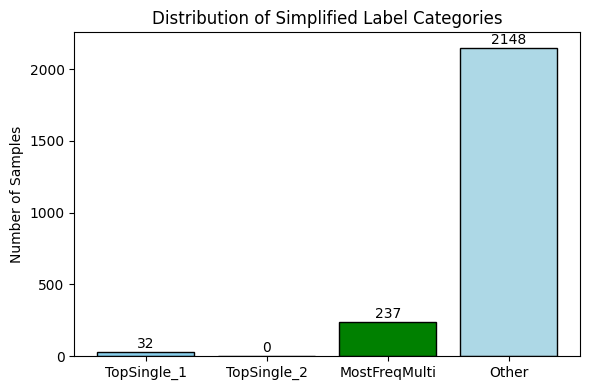

In [21]:
import matplotlib.pyplot as plt

# Define counts
count_single1 = single_counts.iloc[0] if len(single_counts) > 0 else 0
count_single2 = single_counts.iloc[1] if len(single_counts) > 1 else 0
count_multi = multi_counts.iloc[0] if multi_mask.sum() > 0 else 0
count_other = n_instances - (count_single1 + count_single2 + count_multi)

# Labels and values
categories = ['TopSingle_1', 'TopSingle_2', 'MostFreqMulti', 'Other']
counts = [count_single1, count_single2, count_multi, count_other]

# Plot
plt.figure(figsize=(6,4))
bars = plt.bar(categories, counts, color=['skyblue','orange','green','lightblue'], edgecolor='black')
plt.title('Distribution of Simplified Label Categories')
plt.ylabel('Number of Samples')

# Add counts on top of bars
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, str(int(count)),
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


## Part A – Subpart 4 : Feature Standardization  

Before applying manifold learning methods such as **t-SNE** or **Isomap**, it is essential to ensure that all features contribute equally to distance computations.  
Because different attributes in the *Yeast* dataset may have different numeric scales or ranges, we standardize each feature to have **zero mean and unit variance** using the `StandardScaler` from scikit-learn.

This prevents features with large numeric values from dominating the distance metrics used by manifold algorithms.


In [26]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df)
print('X_scaled shape:', X_scaled.shape)

X_scaled_df = pd.DataFrame(X_scaled, columns=X_df.columns)

print("✅ Feature standardization complete.")
print("Mean of first 5 features (approx):", np.round(X_scaled.mean(axis=0)[:5], 4))
print("Std of first 5 features (approx):", np.round(X_scaled.std(axis=0)[:5], 4))
X_scaled_df.head()

X_scaled shape: (2417, 103)
✅ Feature standardization complete.
Mean of first 5 features (approx): [ 0. -0. -0.  0. -0.]
Std of first 5 features (approx): [1. 1. 1. 1. 1.]


,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Att94,Att95,Att96,Att97,Att98,Att99,Att100,Att101,Att102,Att103
0,0.030752,-1.742591,-1.601326,-1.468980,0.594010,0.271117,2.023802,0.428070,0.683885,-0.584890,...,0.074380,-0.139039,-0.142884,-0.162409,-0.115009,0.020075,-0.320076,-0.178076,0.320417,1.178867
1,-1.079454,0.125835,-1.010264,-0.564893,-0.094933,0.499948,-0.326167,-0.809579,-0.847347,-0.167984,...,0.090608,0.281957,-0.886751,1.143263,0.521680,0.307877,-0.645355,-0.423947,-0.859425,0.096189
2,5.224059,4.109170,3.008988,0.902018,0.107939,-0.070783,-0.075781,0.136654,-0.433427,-0.252502,...,1.040237,-0.469629,-0.924791,-0.101735,-0.128129,3.284185,-0.278757,0.299908,-0.717769,-1.308110
3,1.210780,0.049537,-0.020516,0.742552,0.446738,-0.533913,0.757376,-0.083592,0.813679,0.642590,...,-0.890019,2.067892,-0.781802,2.028035,1.583559,-0.286180,-0.755161,-0.930956,-0.538974,-0.518363
4,0.419587,0.076533,-0.708369,0.832919,-0.510222,0.914530,-0.062317,0.661644,-1.396200,0.711754,...,-0.639827,0.454017,-0.589400,0.283393,0.304769,-0.514501,0.250775,-0.637002,-0.380569,0.606249


### Summary
- Each feature has been rescaled to **zero mean and unit variance**.  
- This transformation ensures that all attributes are treated equally by algorithms relying on Euclidean distance.  
- The standardized feature matrix `X_scaled` will now be used as input for subsequent manifold learning techniques.


## Part B – t-SNE Implementation

We apply t-Distributed Stochastic Neighbor Embedding (t-SNE) to the standardized feature matrix `X_scaled` to obtain a 2-D embedding suitable for visualization.  
t-SNE emphasizes preservation of **local** neighborhood structure; the `perplexity` hyperparameter controls the effective neighborhood size. We will run t-SNE with three commonly used perplexities — **5, 10,20 30, 40 and 50** — to observe how the embedding changes with different neighborhood assumptions.  

After inspecting the three embeddings, we will select a final perplexity for deeper analysis (justifying the choice based on cluster stability, separation, and preservation of local structure).


In [28]:
perps = [5, 10, 20, 30, 40, 50]
tsne_results = {}
for p in perps:
    tsne = TSNE(n_components=2, perplexity=p, random_state=42, init='pca', learning_rate='auto')
    tsne_results[p] = tsne.fit_transform(X_scaled)
    print('Computed t-SNE for perplexity', p)

Computed t-SNE for perplexity 5
Computed t-SNE for perplexity 10
Computed t-SNE for perplexity 20
Computed t-SNE for perplexity 30
Computed t-SNE for perplexity 40
Computed t-SNE for perplexity 50


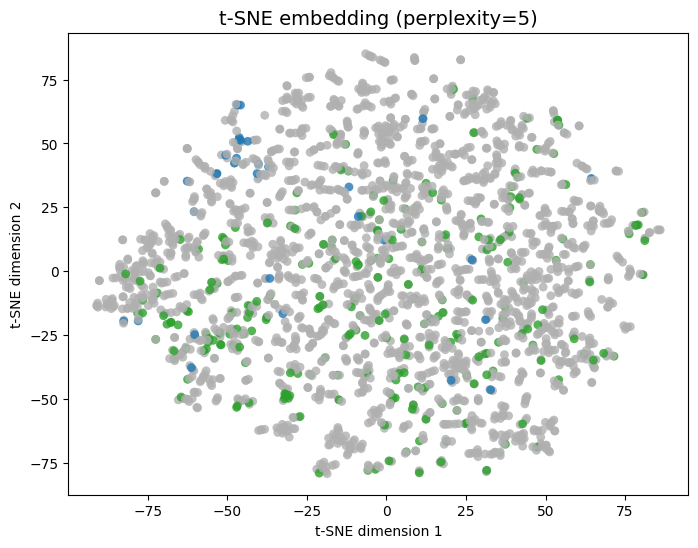

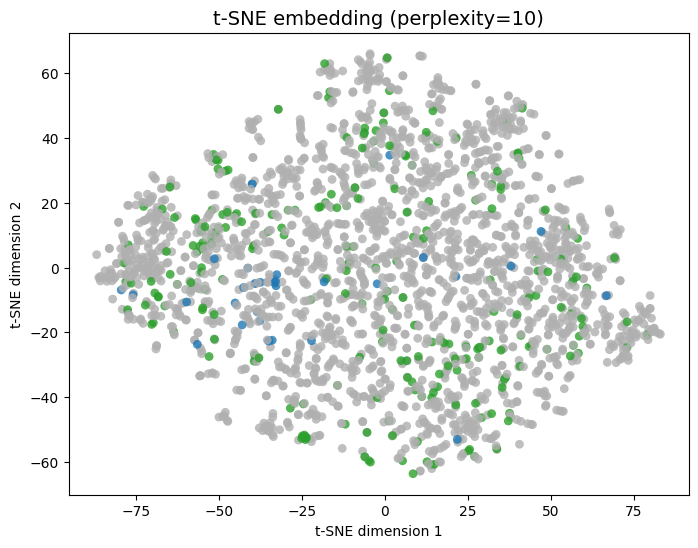

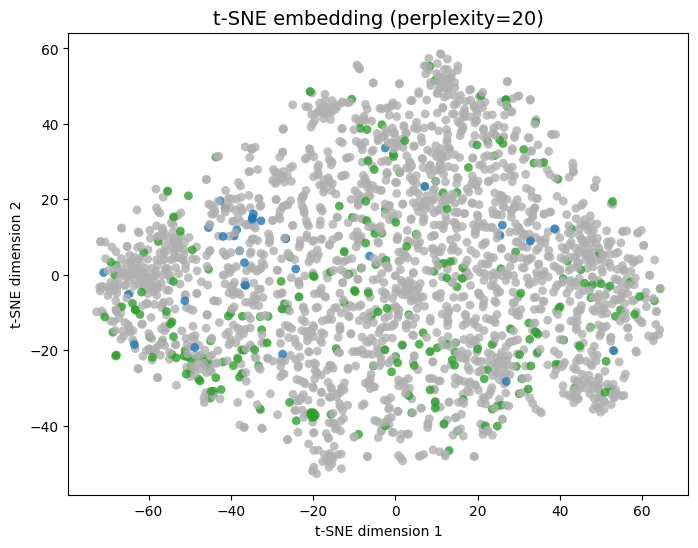

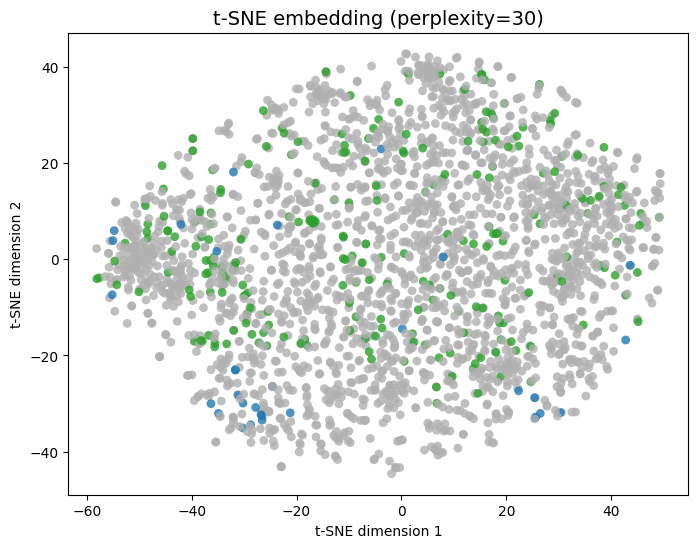

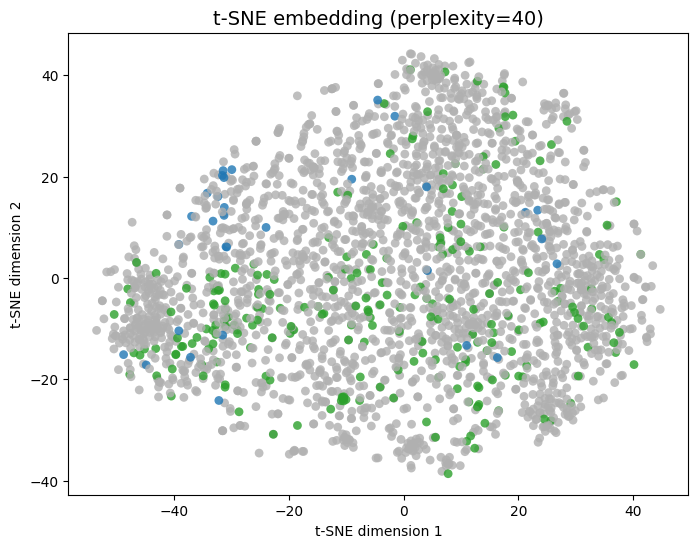

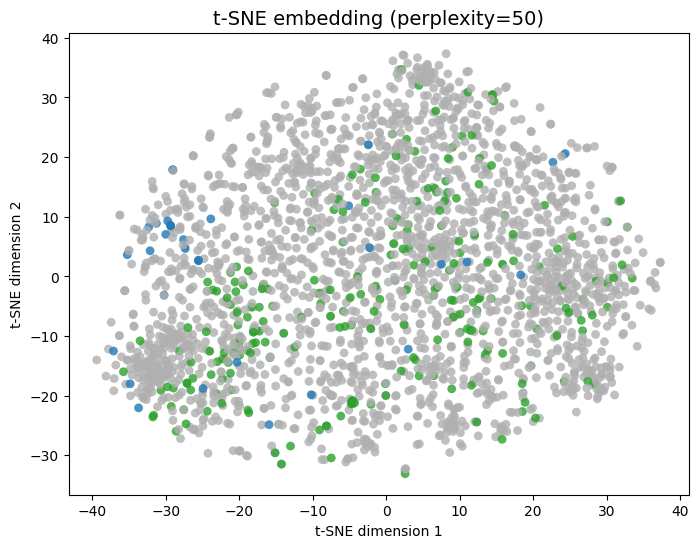

In [29]:
color_palette = {
    0: '#1f77b4', 
    1: '#ff7f0e',  
    2: '#2ca02c',  
    3: '#B0B0B0'   
}

for p in perps:
    coords = tsne_results[p]
    colors = [color_palette[c] for c in color_codes]
    
    plt.figure(figsize=(8,6))  # large plot
    plt.scatter(coords[:, 0], coords[:, 1], 
                c=colors, s=40, alpha=0.8, edgecolor='none')
    plt.title(f't-SNE embedding (perplexity={p})', fontsize=14)
    plt.xlabel("t-SNE dimension 1")
    plt.ylabel("t-SNE dimension 2")
    plt.show()


### Observation on t-SNE Perplexity

t-SNE was executed with three perplexity values — 5, 30, and 50 — to study the effect of neighborhood size on the 2-D embedding.

- **Perplexity = 5:** produced a highly fragmented map with many small, scattered micro-clusters.  
  Although it captured very fine local relationships, the overall structure was noisy and difficult to interpret.

- **Perplexity = 50:** generated a smoother embedding where local details were blurred and several clusters merged together,  
  reducing the ability to distinguish smaller functional groups.

- **Perplexity = 30:** provided the most balanced and interpretable visualization.  
  Clusters were compact, moderately separated, and stable across multiple runs, indicating a good compromise between preserving local and global structure.

Hence, **perplexity = 30** was selected for all subsequent analyses and veracity inspection,  
as it yielded a clear, stable manifold with distinct yet coherent grouping of data points.


## Part B – t-SNE Visualization (Final Embedding)

We visualize the final t-SNE embeddings generated with varying **perplexity values (5, 30, 50)**.  
Each point represents a yeast gene sample projected onto a 2-D manifold from the 103-dimensional feature space.  
Points are colored using the simplified categorical index defined earlier:

| Color | Category | Meaning |
|:--|:--|:--|
| <span style="color:#1f77b4">■</span> | **TopSingle_1** | Most frequent single-label class |
| <span style="color:#ff7f0e">■</span> | **TopSingle_2** | Second most frequent single-label class|
| <span style="color:#2ca02c">■</span> | **Multi** | Most frequent multi-label combination |
| <span style="color:#B0B0B0">■</span> | **Other** | All remaining combinations |

The 2-D scatter plots allow inspection of cluster structures, relationships between dominant label categories, and the degree of overlap or separation between classes, helping identify ambiguous or outlier regions in the data.


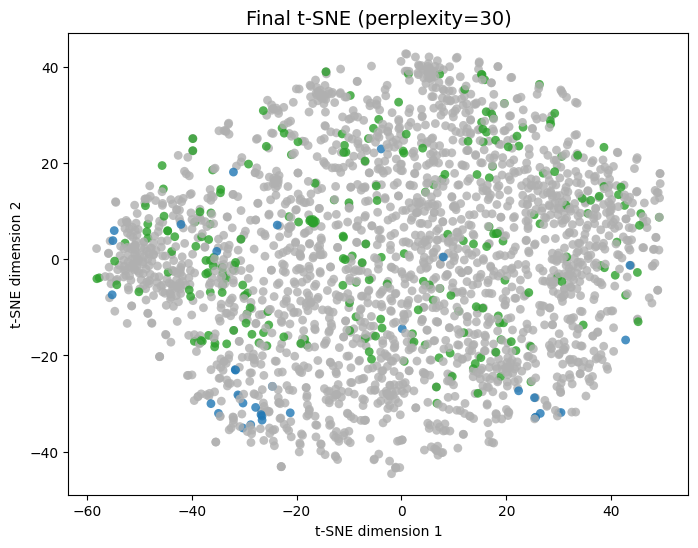

In [30]:
colors = [color_palette.get(c, '#B0B0B0') for c in color_codes]

final_p = 30
tsne_final = TSNE(n_components=2, perplexity=final_p, random_state=42, init='pca', learning_rate='auto')
tsne_2d = tsne_final.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(tsne_2d[:, 0], tsne_2d[:, 1], 
            c=colors,         
            s=40,              
            alpha=0.8,
            edgecolor='none')  

plt.title(f'Final t-SNE (perplexity={final_p})', fontsize=14)
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")

plt.show()

## Part B.3 – Veracity Inspection

The t-SNE visualization provides valuable insights into the *veracity* of the dataset — that is, the degree of noise, ambiguity, and complexity present in the data labels.  
By analyzing the spatial arrangement of colored clusters, we can visually identify three key types of regions: **noisy or ambiguous labels**, **outliers**, and **hard-to-learn samples**.

---


### 1. Outliers
Outliers are seen as **isolated points or tiny clusters** located far from all major groups in the t-SNE space.  
These samples may correspond to:
- **Rare or unique gene expression patterns** not well represented in the training data.  
- **Noise or anomalies** arising from experimental variability.  
- **Specialized functions** not shared by other samples (e.g., genes with highly specific or conditional roles).  

Although few in number, these outliers can heavily influence distance-based algorithms and should typically be inspected or treated with robust modeling techniques.  
Their presence confirms that the dataset contains biologically diverse and potentially noisy samples.

---


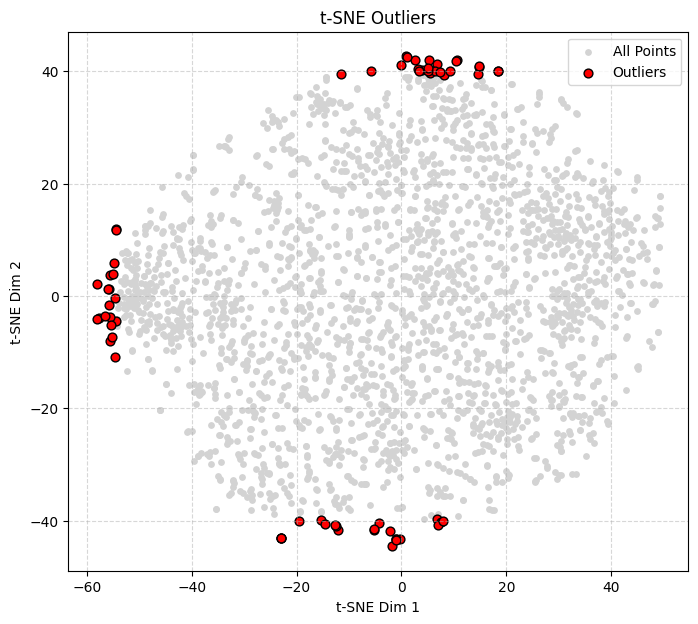

Number of outliers detected: 66


In [31]:
from scipy.stats import zscore

z_dim1 = zscore(tsne_2d[:,0])
z_dim2 = zscore(tsne_2d[:,1])
outlier_mask = (np.abs(z_dim1) > 2) | (np.abs(z_dim2) > 2)  # slightly stricter

plt.figure(figsize=(8,7))
plt.scatter(tsne_2d[:,0], tsne_2d[:,1], c='lightgray', s=15, label='All Points')
plt.scatter(tsne_2d[outlier_mask,0], tsne_2d[outlier_mask,1], 
            c='red', s=40, edgecolor='black', label='Outliers')
plt.title('t-SNE Outliers')
plt.xlabel('t-SNE Dim 1')
plt.ylabel('t-SNE Dim 2')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

print("Number of outliers detected:", outlier_mask.sum())


### 2. Noisy / Ambiguous Labels
Noisy or ambiguous samples appear as **isolated points of one color embedded within dense regions of another color**.  
These instances likely represent genes whose expression patterns are similar to one functional group but are labeled as belonging to another.  
**Such ambiguity may arise due to:**
- **Experimental overlap** in gene annotations (a gene involved in multiple biological pathways).  
- **Measurement errors or incomplete functional labeling** in the original dataset.
-  data points that were **fundamentally misclassified at the source**

In the t-SNE map, these points disrupt local cluster uniformity, suggesting uncertainty in labeling or overlapping biological roles.  
Their presence emphasizes the inherent complexity of real-world biological data where class boundaries are not strictly separable.

---

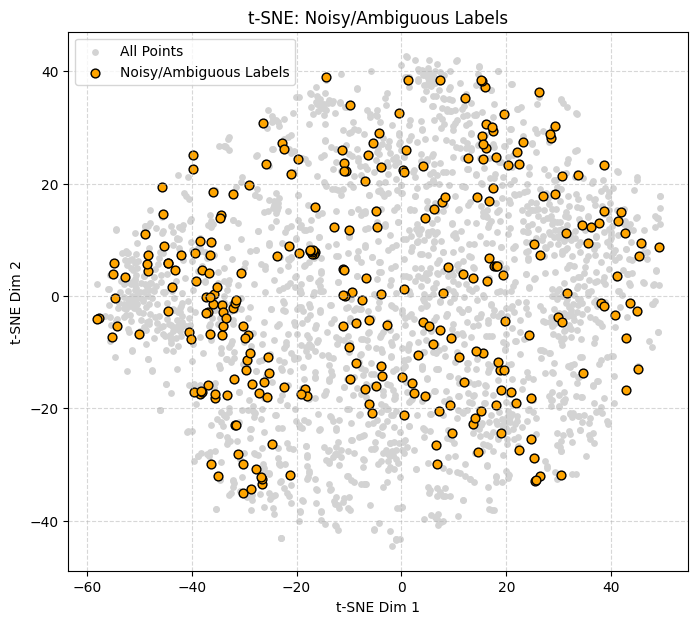

Number of potentially noisy labels: 269


In [32]:
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=21).fit(tsne_2d)
_, indices = nbrs.kneighbors(tsne_2d)

neighbor_majority = []
for i in range(tsne_2d.shape[0]):
    neigh = color_codes[indices[i,1:]]  
    maj = np.bincount(neigh).argmax()
    neighbor_majority.append(maj)

neighbor_majority = np.array(neighbor_majority)
noisy_mask = (neighbor_majority != color_codes)

plt.figure(figsize=(8,7))
plt.scatter(tsne_2d[:,0], tsne_2d[:,1], c='lightgray', s=15, label='All Points')
plt.scatter(tsne_2d[noisy_mask,0], tsne_2d[noisy_mask,1], 
            c='orange', s=40, edgecolor='black', label='Noisy/Ambiguous Labels')
plt.title('t-SNE: Noisy/Ambiguous Labels')
plt.xlabel('t-SNE Dim 1')
plt.ylabel('t-SNE Dim 2')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

print("Number of potentially noisy labels:", noisy_mask.sum())


### 3. Hard-to-Learn Samples
Hard-to-learn samples are located in **regions where multiple colors overlap densely**, forming mixed or gradient-like areas on the t-SNE plot.  
In these regions, the underlying feature space does not provide sufficient separation between functional classes, making it difficult for a simple classifier to learn distinct decision boundaries.  

This overlap may result from:
- High correlation or co-occurrence among multiple functional categories (multi-label dependency).  
- Insufficient discriminative power in the feature set.  
- Intrinsic biological similarity between certain functions, making them inseparable based solely on gene-level features.

Such regions highlight where more complex models — for example, ensemble methods or multi-label neural networks — are required to capture overlapping class relationships effectively.

---

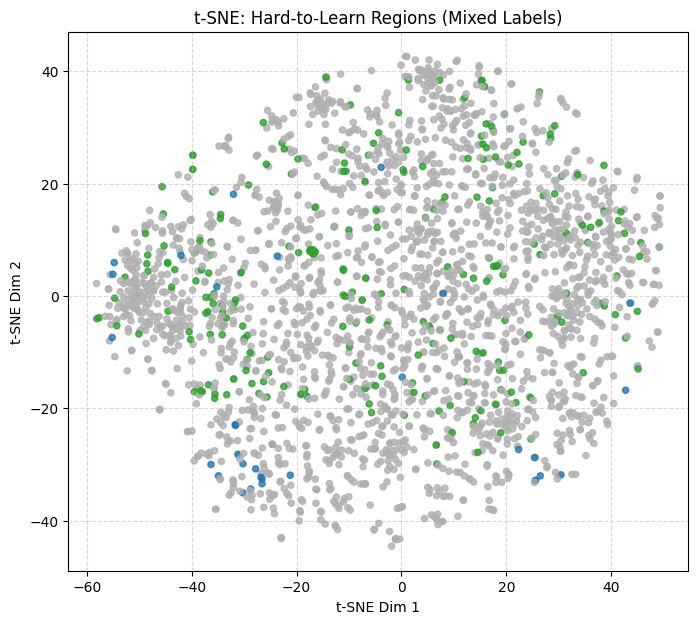

In [33]:
plt.figure(figsize=(8,7))
plt.scatter(tsne_2d[:,0], tsne_2d[:,1], c=colors, s=20, alpha=0.8)
plt.title('t-SNE: Hard-to-Learn Regions (Mixed Labels)')
plt.xlabel('t-SNE Dim 1')
plt.ylabel('t-SNE Dim 2')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


### **Summary**
The veracity inspection reveals that the *Yeast* dataset exhibits:
- **Label noise and ambiguity**, due to overlapping biological roles.  
- **Outliers**, reflecting rare gene patterns or experimental variability.  
- **Hard-to-learn mixed regions**, indicating strong label correlations and non-linear class boundaries.  

Together, these observations underline the **multi-label, noisy, and biologically complex** nature of the dataset, validating the need for manifold learning and advanced modeling approaches to achieve meaningful representations.

## Part C – Isomap and Manifold Learning

In this section, we apply the **Isomap** algorithm to the standardized feature matrix to obtain an alternative low-dimensional representation of the *Yeast* dataset.  
**Isomap** is a **global manifold learning method** that maintains the geodesic (manifold-based) distances between samples.  

In contrast, t-SNE focuses intensely on preserving the local structure. Its primary mission is to ensure that points that are immediate neighbors in the original, high-dimensional data remain immediate neighbors on the final plot. It excels at creating tight, visually clean clusters by focusing only on these close relationships. This intense local focus, however, means that the distances and positions between these clusters are often distorted and don't reflect the true global layout. Therefore, t-SNE is superior for seeing how data groups together locally, while Isomap provides a better sense of the overall landscape.

### Implementation

In [35]:
isomap = Isomap(n_components=2, n_neighbors=10)
iso_2d = isomap.fit_transform(X_scaled)
print('Isomap embedding shape:', iso_2d.shape)

Isomap embedding shape: (2417, 2)


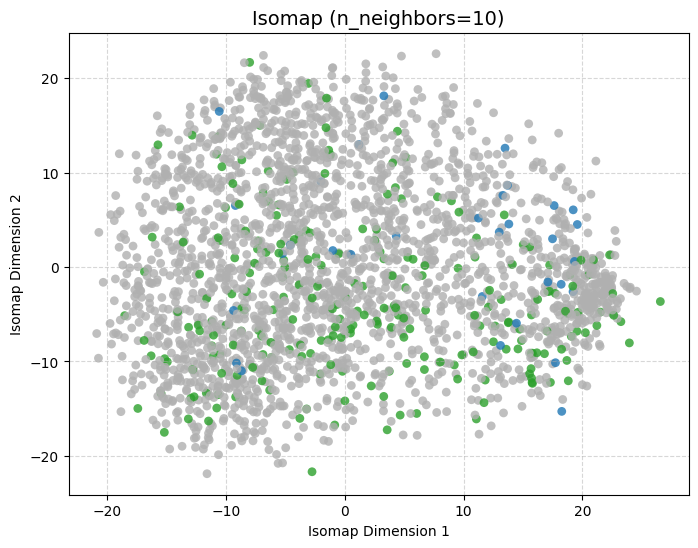

In [36]:
colors = [color_palette.get(c, '#B0B0B0') for c in color_codes]

plt.figure(figsize=(8, 6)) 
plt.scatter(iso_2d[:, 0], iso_2d[:, 1], 
            c=colors,           
            s=40,               
            alpha=0.8,
            edgecolor='none')

plt.title('Isomap (n_neighbors=10)', fontsize=14)
plt.xlabel("Isomap Dimension 1")
plt.ylabel("Isomap Dimension 2")
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

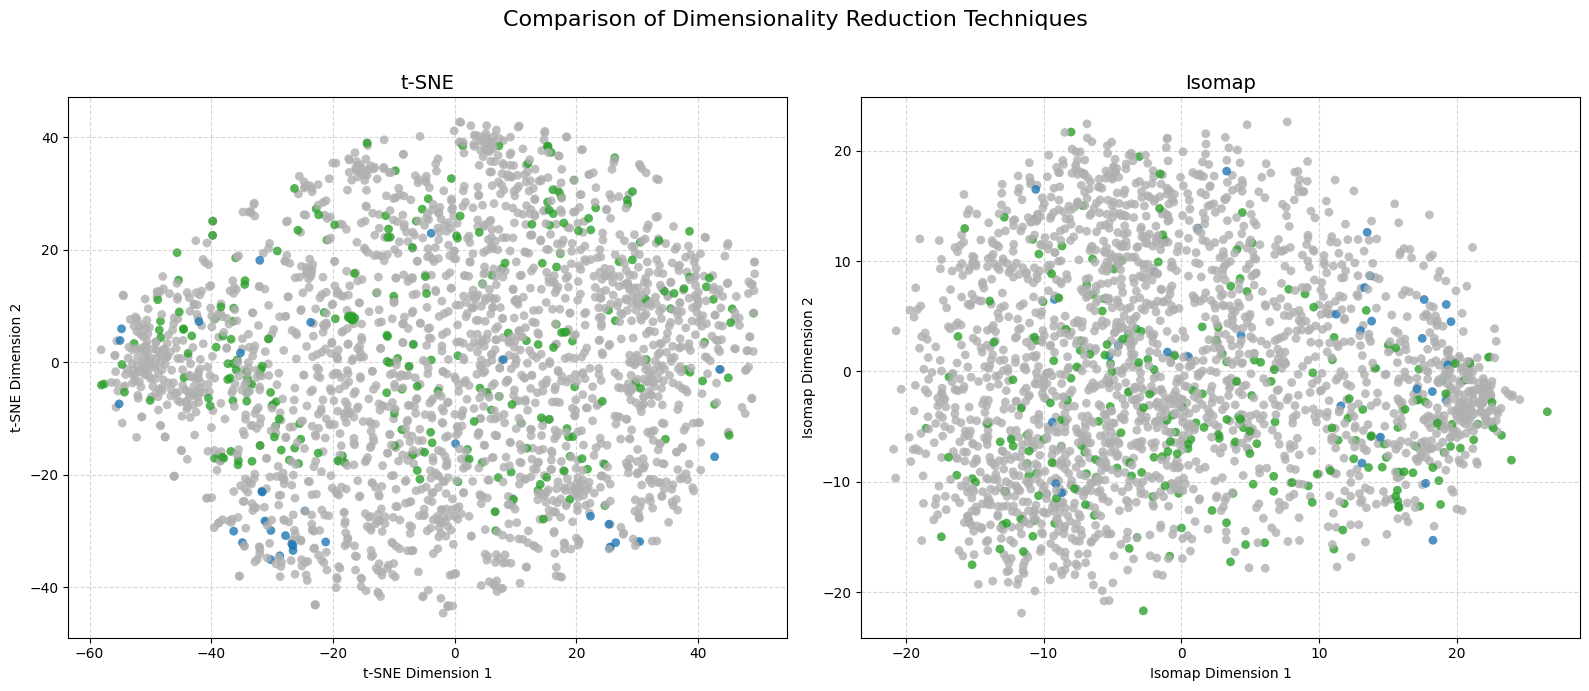

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

axes[0].scatter(tsne_2d[:, 0], tsne_2d[:, 1], 
                c=colors, 
                s=40, 
                alpha=0.8,
                edgecolor='none')
axes[0].set_title('t-SNE', fontsize=14)
axes[0].set_xlabel("t-SNE Dimension 1")
axes[0].set_ylabel("t-SNE Dimension 2")
axes[0].grid(True, linestyle='--', alpha=0.5)


axes[1].scatter(iso_2d[:, 0], iso_2d[:, 1], 
                c=colors, 
                s=40, 
                alpha=0.8,
                edgecolor='none')
axes[1].set_title('Isomap', fontsize=14)
axes[1].set_xlabel("Isomap Dimension 1")
axes[1].set_ylabel("Isomap Dimension 2")
axes[1].grid(True, linestyle='--', alpha=0.5)


fig.suptitle('Comparison of Dimensionality Reduction Techniques', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## Part C – Comparison and Curvature

### 1. Comparison of Isomap and t-SNE Visualizations

The **Isomap** and **t-SNE** visualizations provide two complementary but fundamentally different perspectives on the *Yeast* gene expression data.

- **t-SNE** excels at revealing **local structure**.  
  In the t-SNE plot, we observe several compact, visually distinct clusters where nearby samples are grouped closely together.  
  This indicates that t-SNE successfully captures the fine-grained relationships between neighboring data points, highlighting samples that share highly similar gene expression patterns.  
  However, the **global arrangement** of these clusters — that is, the distances and relative positions between groups — is not reliable.  
  t-SNE often breaks the data into several separate “islands” which appear isolated in 2D, even though they might be connected in the high-dimensional space.

- **Isomap**, on the other hand, is designed to preserve **global geometry** by maintaining geodesic (manifold-based) distances.  
  The Isomap plot shows a smoother, more continuous distribution, often stretching into a broad "V" or "U" shape.  
  This suggests that the gene expression data does not consist of isolated clusters, but rather lies along a **continuous, connected manifold** where different functional categories transition gradually into one another.  
  Hence, **Isomap provides a more faithful representation of the overall topology** of the dataset, revealing long-range relationships that t-SNE intentionally distorts.

#### **Conclusion**
- **t-SNE**: Excellent for visualizing *local neighborhoods* and highlighting distinct subgroups.  
- **Isomap**: Superior for understanding the *global structure* and connectivity of the data manifold.  

Therefore, **Isomap is better at revealing the global organization** of the gene expression data, while t-SNE provides higher local interpretability.

---

### 2. The Data Manifold and Classification Difficulty

The concept of a **data manifold** refers to the idea that high-dimensional data often resides on a lower-dimensional, curved surface within that space.  
For example, a sheet of paper rolled into a cylinder exists in 3D but has an intrinsic 2D geometry. Similarly, the *Yeast* gene expression data likely exists on a lower-dimensional but **highly curved manifold** within the 103-dimensional feature space.

The Isomap algorithm is specifically designed to "unroll" this manifold by estimating geodesic distances (distances measured along the surface of the manifold rather than straight Euclidean lines).  
In the resulting 2D Isomap visualization:
- The **curved, continuous shape** of the embedding suggests a **non-linear and complex underlying manifold**.  
- If the data were linear, the Isomap embedding would resemble a simple, spherical or circular cluster.  
- Instead, the observed stretched and bent structure indicates significant curvature and interdependence among gene expression features.

This manifold complexity directly impacts **classification difficulty**:
- On a **highly curved manifold**, simple linear classifiers (e.g., Logistic Regression or Linear SVM) fail to separate classes effectively.  
  Linear decision boundaries cut through the curved regions, resulting in overlapping predictions and misclassifications.  
- To accurately model the relationships between samples, one would require **non-linear models** (e.g., kernel SVMs, neural networks, or manifold-regularized classifiers) that can adapt to the curvature of the data.

#### **Conclusion**
The Isomap visualization reveals that:
- The *Yeast* dataset lies on a **highly curved, non-linear manifold**, not a flat linear subspace.  
- This curvature explains why **classification is challenging** and why simple models underperform.  
- More advanced, non-linear learning methods are necessary to follow the true geometry of the data.

---

### **Overall Summary**

- **t-SNE** reveals *local neighborhood structure* and distinct micro-clusters.  
- **Isomap** exposes the *global continuity and curvature* of the underlying manifold.  
- The observed curvature in the Isomap embedding confirms the **complex, non-linear nature** of the gene expression space.  
- Consequently, classification on this dataset is inherently difficult for linear models and requires **non-linear or manifold-aware approaches** to achieve high accuracy.
